## Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  sample_data/


## Change to the data dir

In [2]:
import os
os.chdir('/content/drive/MyDrive/ModelNet10')
%ls

bathtub/  bed/  chair/  desk/  dresser/  monitor/  night_stand/  README.txt  sofa/  table/  toilet/


## read .off files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, _ = tuple([int(s) for s in file.readline().strip().split(' ')])
    vertices = [[float(s) for s in file.readline().strip().split(' ')] for i in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i in range(n_faces)]
    return np.array(vertices), np.array(faces)

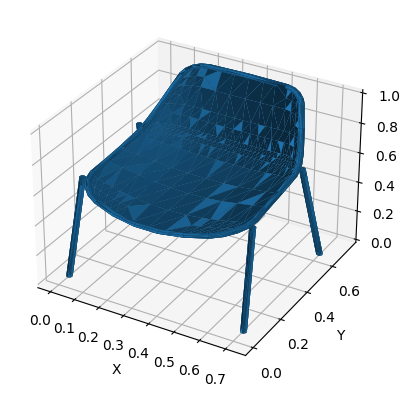

In [4]:
def plot_mesh(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces[670:671], shade=True)
    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, shade=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    #ax.plot([1,1], [-5,-5],[1,20], marker='o')
    plt.show()

def fit_to_unit_cube(vertices):
    min_vals = vertices.min(axis=0)
    max_vals = vertices.max(axis=0)
    scale = max(max_vals - min_vals)
    return (vertices - min_vals) / scale
# Example usage
file_path = 'chair/test/chair_0890.off'
with open(file_path, 'r') as file:
    vertices, faces = read_off(file)
#    print(faces[670:671])
#    print(vertices[402])
#    print(vertices[368])
#    print(vertices[426])
    vertices = fit_to_unit_cube(vertices)
    plot_mesh(vertices, faces)

In [5]:
def plane_projection(point, point_in_screen, normal_vector):
  # point: position vector of a point to be projected onto a plane
  # point_in_plane: position of a point in the scree
  # normal_vector: direction perpendicular to the scree
  p, s, n = point, point_in_screen, normal_vector
  n /= np.linalg.norm(n)
  x = np.dot(s-p, n)
  distance = abs(x)
  p_s = p + x * n
  assert abs(np.dot(p_s-s, n)) < 1e-5
  return distance, p_s
point = np.array([1.,1.,1.])
point_in_screen = np.array([1.,0.,0.])
normal_vector = np.array([1.,1.,1.])
print(plane_projection(point, point_in_screen, normal_vector))

(1.1547005383792517, array([0.33333333, 0.33333333, 0.33333333]))


In [6]:
def get_coordinate_in_screen(origin, x_axis, y_axis, normal, point):
  x_axis /= np.linalg.norm(x_axis)
  y_axis /= np.linalg.norm(y_axis)
  normal /= np.linalg.norm(normal)
  if abs(np.dot(point-origin, normal))> 1e-5:
    print("the point provided is not in the screen.")
    return None
  p = point-origin
  return np.dot(p, x_axis), np.dot(p, y_axis)


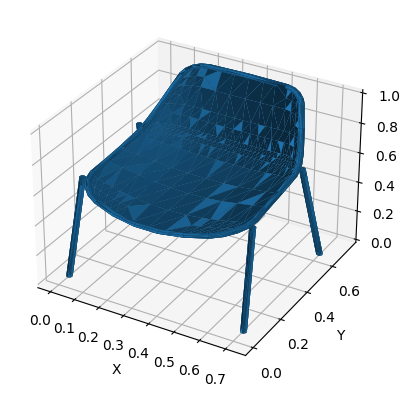

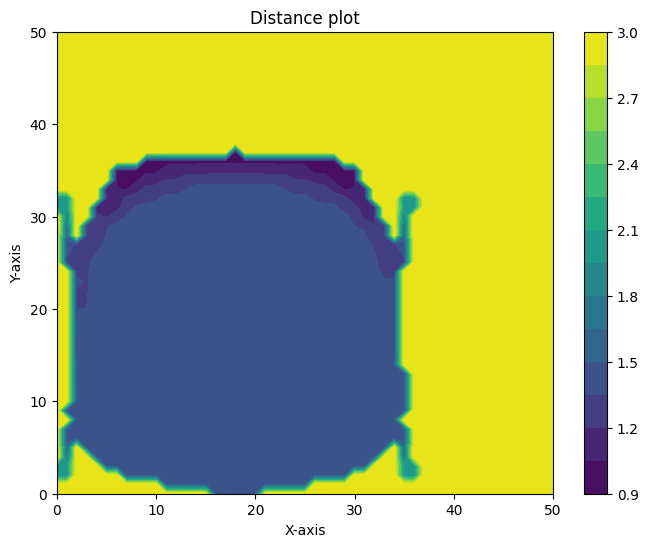

<Figure size 800x600 with 0 Axes>

In [35]:
# Example usage
file_path = 'chair/test/chair_0890.off'
with open(file_path, 'r') as file:
  vertices, faces = read_off(file)
#    print(faces[670:671])
#    print(vertices[402])
#    print(vertices[368])
#    print(vertices[426])
  vertices = fit_to_unit_cube(vertices)
  plot_mesh(vertices, faces)
  origin = np.array([0.,0.,2.])
  x_axis = np.array([1.,0.,0.])
  y_axis = np.array([0.,1.,0.])
  normal = np.cross(x_axis, y_axis)
  npixels = 50
  screen = np.ones((npixels+1,npixels+1)) * 3.
  plt.figure(figsize=(8, 6))
  for f in faces:
    # now deal with one face
    nv_f = len(f)
    v, dis, v_s =  np.zeros((nv_f, 3)), np.zeros(nv_f), np.zeros((nv_f, 3))
    coord, coord_px = np.zeros((nv_f, 2)), np.zeros((nv_f, 2),dtype=np.int32)
    for i_f, i in enumerate(f):
      v[i_f] = vertices[i]
      dis[i_f], v_s[i_f] = plane_projection(v[i_f], origin, normal)
      coord[i_f] = get_coordinate_in_screen(origin, x_axis, y_axis, normal, v_s[i_f])
      coord_px[i_f] = np.round(coord[i_f]*npixels).astype(int)
      screen[coord_px[i_f][0], coord_px[i_f][1]] = dis[i_f]
    O_px, A_px, B_px = coord_px[1], coord_px[2], coord_px[0]
#    print("O_px, A_px, B_px: ", O_px, A_px, B_px)
    OA_px, OB_px = A_px-O_px, B_px-O_px
    if np.abs(np.cross(OA_px,OB_px))<1e-5: continue
#    print("OA_px, OB_px: ", OA_px, OB_px)
    for a_x in range(0, (OA_px[0] if OA_px[0]!=0 else 1), np.sign(OA_px[0])if OA_px[0]!=0 else 1):
      for b_x in range(0, (OB_px[0] if OB_px[0]!=0 else 1), np.sign(OB_px[0])if OB_px[0]!=0 else 1):
        for a_y in range(0, (OA_px[1] if OA_px[1]!=0 else 1), np.sign(OA_px[1])if OA_px[1]!=0 else 1):
          for b_y in range(0, (OB_px[1] if OB_px[1]!=0 else 1), np.sign(OB_px[1])if OB_px[1]!=0 else 1):
            d_px = np.array([a_x+b_x, a_y+b_y])
            # f_A*OA_px+f_B*OB_px = d_px
            coeff = np.array([OA_px, OB_px])
            f = np.einsum('i,ij->j',d_px, np.linalg.inv(coeff))
            newx, newy = O_px[0] + d_px[0], O_px[1] + d_px[1]
            if f[0]+f[1]<=1.1 and f[0]>=-0.05 and f[1]>=-0.05:
              screen[newx, newy] = min(screen[newx, newy], dis[1] + f[0]*(dis[2]-dis[1])+f[1]*(dis[0]-dis[1]))
  contour = plt.contourf(screen.transpose(), levels=15, cmap='viridis')
  plt.colorbar(contour)
  plt.title('Distance plot')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.figure(figsize=(8, 6))

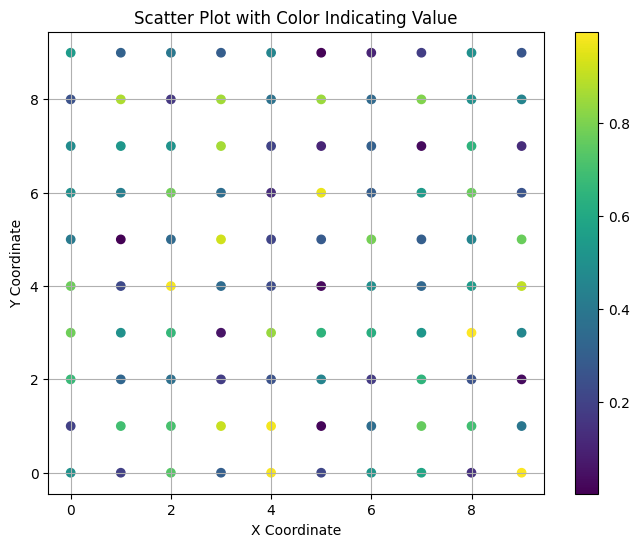

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random 2D array
data = np.random.rand(10, 10)

# Prepare data for plotting
x, y, c = [], [], []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        x.append(j)
        y.append(i)
        c.append(data[i, j])

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=c, cmap='viridis')
plt.colorbar(scatter)
plt.grid(True)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot with Color Indicating Value')
plt.show()
